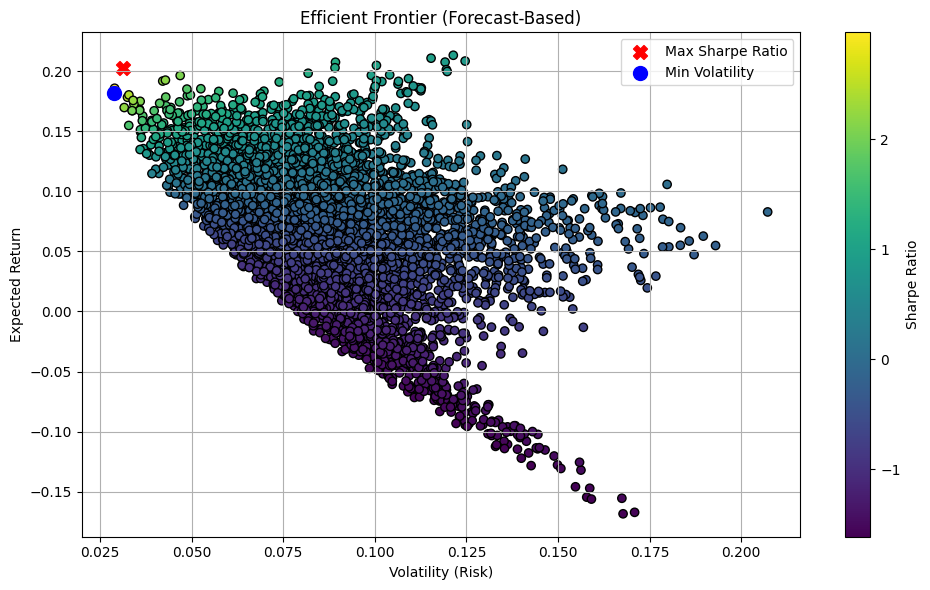

,Ticker,Weight (Max Sharpe),Weight (Min Risk)
0,SYNE3.SA,5.221962e-02,3.236350e-02
1,PLPL3.SA,3.094968e-02,1.337800e-01
2,CMIN3.SA,0.000000e+00,1.009977e-02
3,SOND6.SA,3.291758e-14,1.853873e-02
4,WHRL3.SA,6.735636e-15,1.084202e-19
5,DIRR3.SA,9.168307e-01,8.052180e-01


In [1]:
# 06_markowitz_optimization.ipynb
# Author: André Lopes Marinho
# Description:
# Automatically loads Prophet forecast CSVs, calculates expected returns & risk,
# and applies Markowitz portfolio optimization with visualization.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import os

# Step 1: Parameters
forecast_dir = '../data'
tickers = ['SYNE3.SA', 'PLPL3.SA', 'CMIN3.SA', 'SOND6.SA', 'WHRL3.SA', 'DIRR3.SA']
rf = 0.10  # 10% risk-free rate (Selic)

expected_returns = {}
volatilities = {}

# Step 2: Extract return and volatility from Prophet forecasts
for ticker in tickers:
    file_path = os.path.join(forecast_dir, f'forecast_{ticker}.csv')
    if not os.path.exists(file_path):
        print(f"⚠️ Missing forecast file for {ticker}, skipping.")
        continue

    df = pd.read_csv(file_path, parse_dates=['ds'])
    future = df[df['ds'] > df['ds'].max() - pd.Timedelta(days=180)]

    if future.shape[0] < 2:
        print(f"⚠️ Not enough forecast data for {ticker}, skipping.")
        continue

    yhat_returns = future['yhat'].pct_change().dropna()

    if yhat_returns.empty:
        print(f"⚠️ No returns calculated for {ticker}, skipping.")
        continue

    expected_returns[ticker] = yhat_returns.mean() * 252
    volatilities[ticker] = yhat_returns.std() * np.sqrt(252)

# Step 3: Prepare for optimization
tickers = list(expected_returns.keys())
returns = pd.Series(expected_returns)
n_assets = len(tickers)

# Generate synthetic covariance matrix
np.random.seed(42)
simulated = np.random.normal(loc=returns.values, scale=[volatilities[t] for t in tickers], size=(252, n_assets))
cov_matrix = np.cov(simulated, rowvar=False)

# Performance function
def portfolio_performance(weights, returns, cov_matrix, rf):
    ret = np.dot(weights, returns)
    vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe = (ret - rf) / vol
    return ret, vol, sharpe

# Optimization functions
def neg_sharpe(weights): return -portfolio_performance(weights, returns, cov_matrix, rf)[2]
def min_var(weights): return np.dot(weights.T, np.dot(cov_matrix, weights))
def constraint(): return {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
def bounds(n): return tuple((0, 1) for _ in range(n))

# Initial weights
init = np.array([1/n_assets] * n_assets)

# Step 4: Optimize
opt_sharpe = minimize(neg_sharpe, init, method='SLSQP', bounds=bounds(n_assets), constraints=constraint())
opt_min_var = minimize(min_var, init, method='SLSQP', bounds=bounds(n_assets), constraints=constraint())

# Step 5: Simulate efficient frontier
n_portfolios = 5000
weights_array = np.random.dirichlet(np.ones(n_assets), n_portfolios)
rets = weights_array @ returns.values
vols = np.sqrt(np.sum(weights_array @ cov_matrix * weights_array, axis=1))
sharpes = (rets - rf) / vols

# Step 6: Plot efficient frontier
plt.figure(figsize=(10, 6))
scatter = plt.scatter(vols, rets, c=sharpes, cmap='viridis', edgecolor='black')
plt.colorbar(scatter, label='Sharpe Ratio')

opt_ret, opt_vol, _ = portfolio_performance(opt_sharpe.x, returns, cov_matrix, rf)
min_ret, min_vol, _ = portfolio_performance(opt_min_var.x, returns, cov_matrix, rf)

plt.scatter(opt_vol, opt_ret, c='red', s=100, label='Max Sharpe Ratio', marker='X')
plt.scatter(min_vol, min_ret, c='blue', s=100, label='Min Volatility', marker='o')
plt.title('Efficient Frontier (Forecast-Based)')
plt.xlabel('Volatility (Risk)')
plt.ylabel('Expected Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 7: Display final portfolio weights
results = pd.DataFrame({
    'Ticker': tickers,
    'Weight (Max Sharpe)': opt_sharpe.x,
    'Weight (Min Risk)': opt_min_var.x
})
display(results)
